In [1]:
import warnings
warnings.simplefilter('ignore')
from neurocaps import TimeseriesExtractor, CAP

help(TimeseriesExtractor)

extractor = TimeseriesExtractor(n_rois=400, n_networks=17)

Help on class TimeseriesExtractor in module neurocaps.timeseriesextractor:

class TimeseriesExtractor(neurocaps.getters.timeseriesextractorgetter._TimeseriesExtractorGetter)
 |  TimeseriesExtractor(space: str = 'MNI152NLin2009cAsym', standardize: Union[bool, str] = False, n_rois: int = 400, n_networks: int = 7, use_confounds: bool = True, confound_names: list[str] = None)
 |  
 |  Method resolution order:
 |      TimeseriesExtractor
 |      neurocaps.getters.timeseriesextractorgetter._TimeseriesExtractorGetter
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, space: str = 'MNI152NLin2009cAsym', standardize: Union[bool, str] = False, n_rois: int = 400, n_networks: int = 7, use_confounds: bool = True, confound_names: list[str] = None)
 |      Timeseries Extractor Class
 |      
 |      Initializes a TimeseriesExtractor to prepare for Co-activation Patterns (CAPs) analysis.
 |      
 |      Parameters
 |      ----------
 |      space : str, default="MNI152NLin

In [2]:
help(extractor.get_bold)

Help on method get_bold in module neurocaps.timeseriesextractor:

get_bold(bids_dir: str, session: int, runs: list[int] = None, task: str = 'rest', condition: str = None, tr: Union[int, float] = None, run_subjects: list[str] = None, pipeline_name: str = None) -> None method of neurocaps.timeseriesextractor.TimeseriesExtractor instance
    Get Bold Data
    
    Collects files needed to extract timeseries data from NIfTI files for BIDS-compliant datasets.
    
    Parameters
    ----------
    bids_dir : str
        Path to a BIDS compliant directory. 
    session : int
        Session number.
    run : list[int]
        Run number to extract timeseries data from. Extracts all runs if unspecified.
    task : str, default="rest"
        Task name.
    condition : str, default=None
        Specific condition in the task to extract from
    tr : int or float, default=None
        Repetition time.
    run_subjects : List[str], default=None
        List of subject IDs to process. Processes a

In [3]:
# Attributes

print(dir(extractor))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_atlas', '_atlas_labels', '_atlas_networks', '_confound_names', '_extract_timeseries', '_n_networks', '_n_rois', '_space', '_standardize', '_use_confounds', 'atlas', 'atlas_indices', 'atlas_labels', 'atlas_networks', 'condition', 'confound_names', 'get_bold', 'n_networks', 'n_rois', 'run', 'session', 'space', 'standardize', 'subject_ids', 'subject_timeseries', 'task', 'timeseries_to_pickle', 'tr', 'use_confounds', 'visualize_bold']


In [4]:
# Generating a sample subject timeseries that extractor.get_bold would produce using numpy

import numpy as np

extractor._subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(100,400) for y in range(1,4)} for x in range(1,11)}

extractor.subject_timeseries

{'1': {'run-1': array([[0.32399024, 0.00956502, 0.4552884 , ..., 0.22397745, 0.54959895,
          0.70191652],
         [0.18789725, 0.18721918, 0.243458  , ..., 0.65485535, 0.72401863,
          0.39530469],
         [0.82925325, 0.38979738, 0.47534865, ..., 0.0153843 , 0.07318722,
          0.72412147],
         ...,
         [0.4450023 , 0.76481804, 0.13980225, ..., 0.38501347, 0.7302835 ,
          0.19297773],
         [0.75662021, 0.34287705, 0.09366209, ..., 0.0009994 , 0.09676228,
          0.92616809],
         [0.65459152, 0.79794244, 0.09678397, ..., 0.90274701, 0.68180802,
          0.73544918]]),
  'run-2': array([[0.09030358, 0.3274011 , 0.80941173, ..., 0.63959543, 0.66373843,
          0.88445137],
         [0.22130676, 0.42233417, 0.4215759 , ..., 0.19026562, 0.59532694,
          0.08077033],
         [0.65080813, 0.14974874, 0.31528568, ..., 0.85101587, 0.83190001,
          0.39684104],
         ...,
         [0.93832683, 0.69567722, 0.45869237, ..., 0.65884309, 0.

In [5]:
# Save randomly generated data in directory where jupyter notebook is running

import os, pickle

output_dir = os.path.dirname(__vsc_ipynb_file__)

extractor.timeseries_to_pickle(output_dir=output_dir, file_name="sample_timeseries")

with open("sample_timeseries.pkl", "rb") as f:
    subject_timeseries = pickle.load(f)

print(subject_timeseries)

{'1': {'run-1': array([[0.32399024, 0.00956502, 0.4552884 , ..., 0.22397745, 0.54959895,
        0.70191652],
       [0.18789725, 0.18721918, 0.243458  , ..., 0.65485535, 0.72401863,
        0.39530469],
       [0.82925325, 0.38979738, 0.47534865, ..., 0.0153843 , 0.07318722,
        0.72412147],
       ...,
       [0.4450023 , 0.76481804, 0.13980225, ..., 0.38501347, 0.7302835 ,
        0.19297773],
       [0.75662021, 0.34287705, 0.09366209, ..., 0.0009994 , 0.09676228,
        0.92616809],
       [0.65459152, 0.79794244, 0.09678397, ..., 0.90274701, 0.68180802,
        0.73544918]]), 'run-2': array([[0.09030358, 0.3274011 , 0.80941173, ..., 0.63959543, 0.66373843,
        0.88445137],
       [0.22130676, 0.42233417, 0.4215759 , ..., 0.19026562, 0.59532694,
        0.08077033],
       [0.65080813, 0.14974874, 0.31528568, ..., 0.85101587, 0.83190001,
        0.39684104],
       ...,
       [0.93832683, 0.69567722, 0.45869237, ..., 0.65884309, 0.38373294,
        0.36140361],
       [0

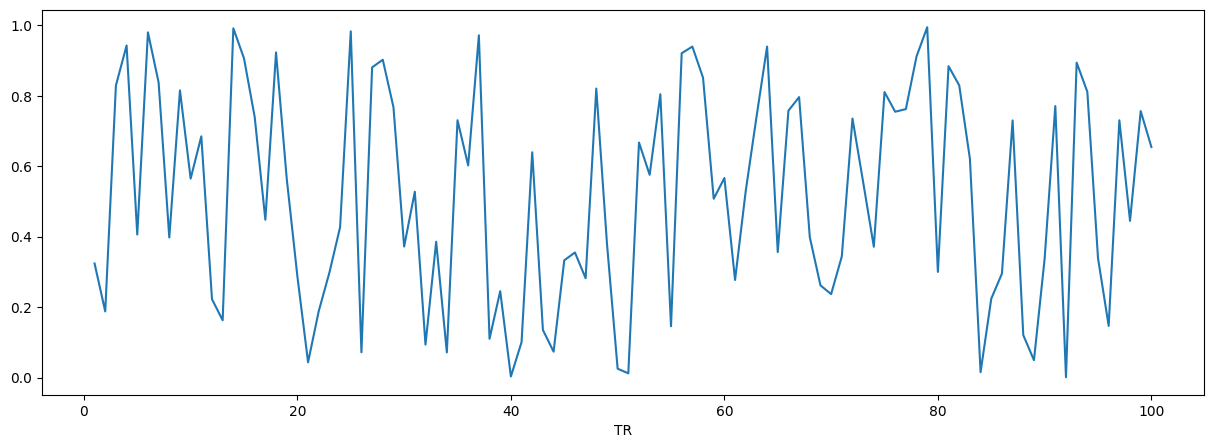

In [6]:
# Visualize Bold at node level

extractor.visualize_bold(subj_id="1",run=1, roi_indx=0)

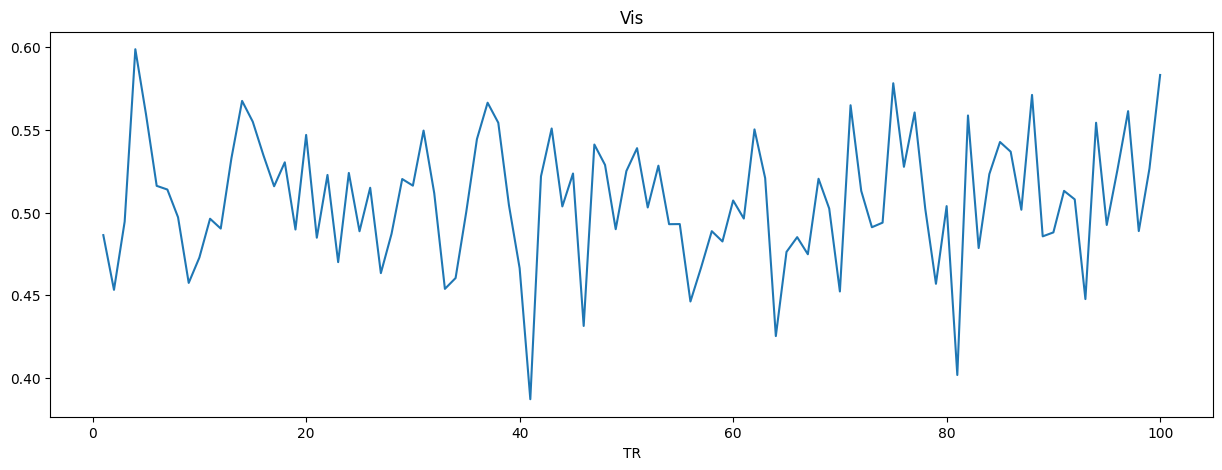

In [7]:
# Visualize Bold at network level

extractor.visualize_bold(subj_id="1",run=1, network="Vis")

In [8]:
# Performing Cap analysis with all subjects 

cap_analysis = CAP(node_labels=extractor.atlas_labels, n_clusters=3)

cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries)

Optimal cluster size for A is 6.

Optimal cluster size for B is 7.



{'A': KMeans(n_clusters=6), 'B': KMeans(n_clusters=7)}

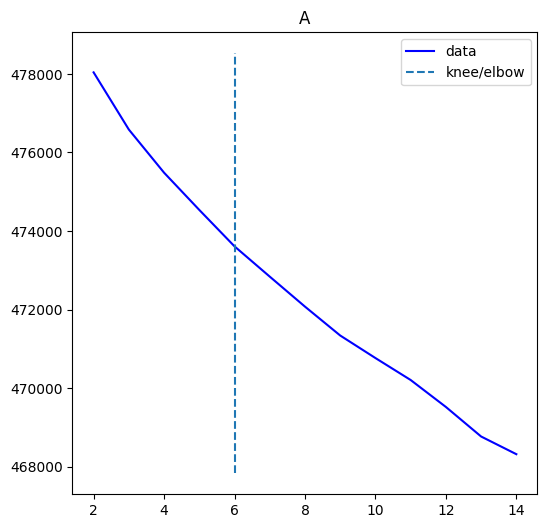

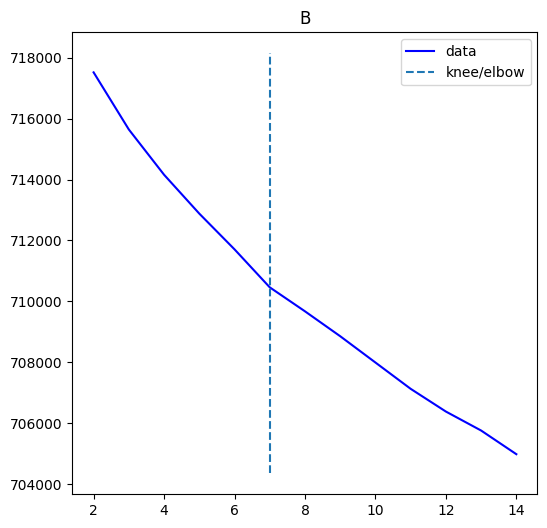

In [9]:
# Performing Cap analysis with groups, list of n_clusters, and elbow cluster selection method

cap_analysis = CAP(node_labels=extractor.atlas_labels, groups={"A": ["1","2","3","5"], "B": ["4","6","7","8","9","10","11"]}, n_clusters=list(range(2,15)), cluster_selection_method="elbow")

# When elbow method is specified, the associated plots will be shown, furthermore, the saved kmeans model for each group will automatically save to the optimal cluster size
cap_analysis.get_caps(subject_timeseries="sample_timeseries.pkl")

cap_analysis.kmeans

In [10]:
# Performing Cap analysis with groups, list of n_clusters, and silhouette cluster selection method

cap_analysis = CAP(node_labels=extractor.atlas_labels, groups={"A": ["1","2","3","5"], "B": ["4","6","7","8","9","10","11"]}, n_clusters=list(range(2,4)), cluster_selection_method="silhouette")

cap_analysis.get_caps(subject_timeseries="sample_timeseries.pkl")

# kmeans model automatically save to the optimal size
cap_analysis.kmeans

Optimal cluster size for A is 2.
Optimal cluster size for B is 2.


{'A': KMeans(n_clusters=2), 'B': KMeans(n_clusters=2)}

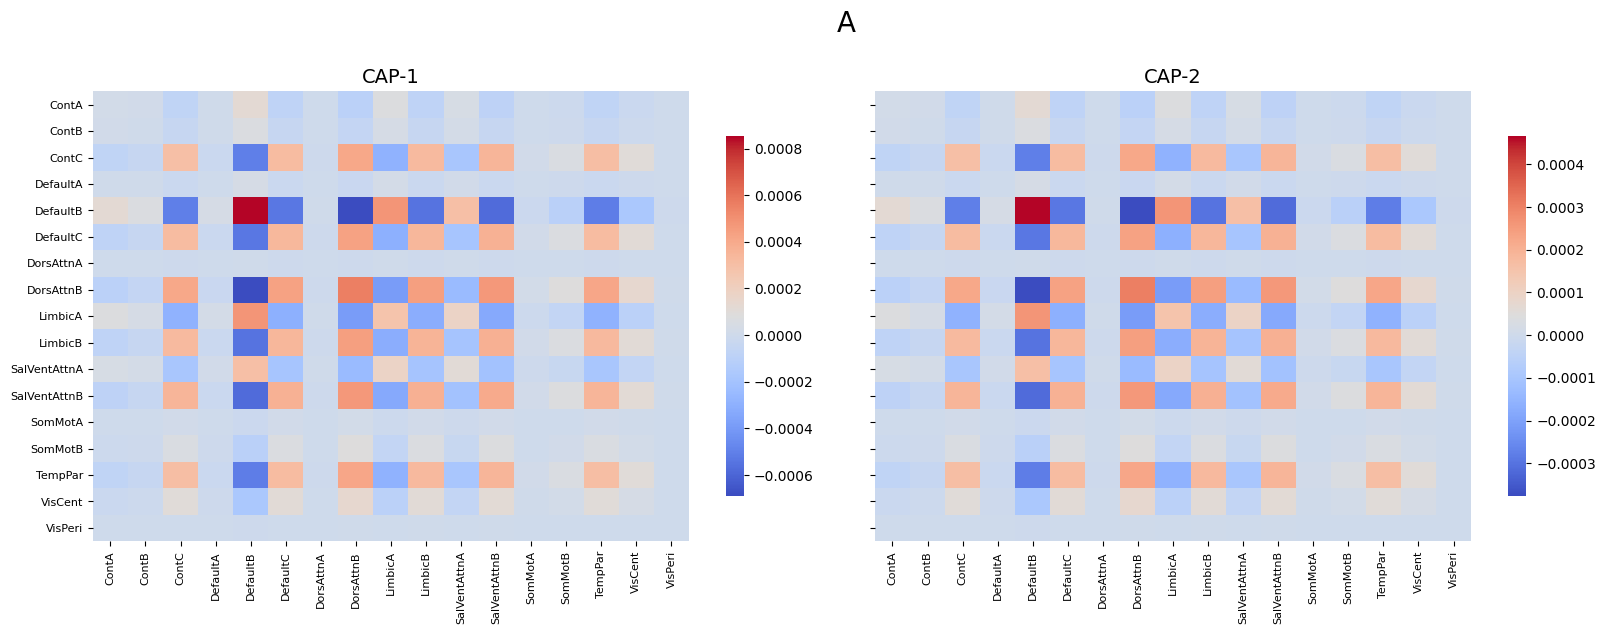

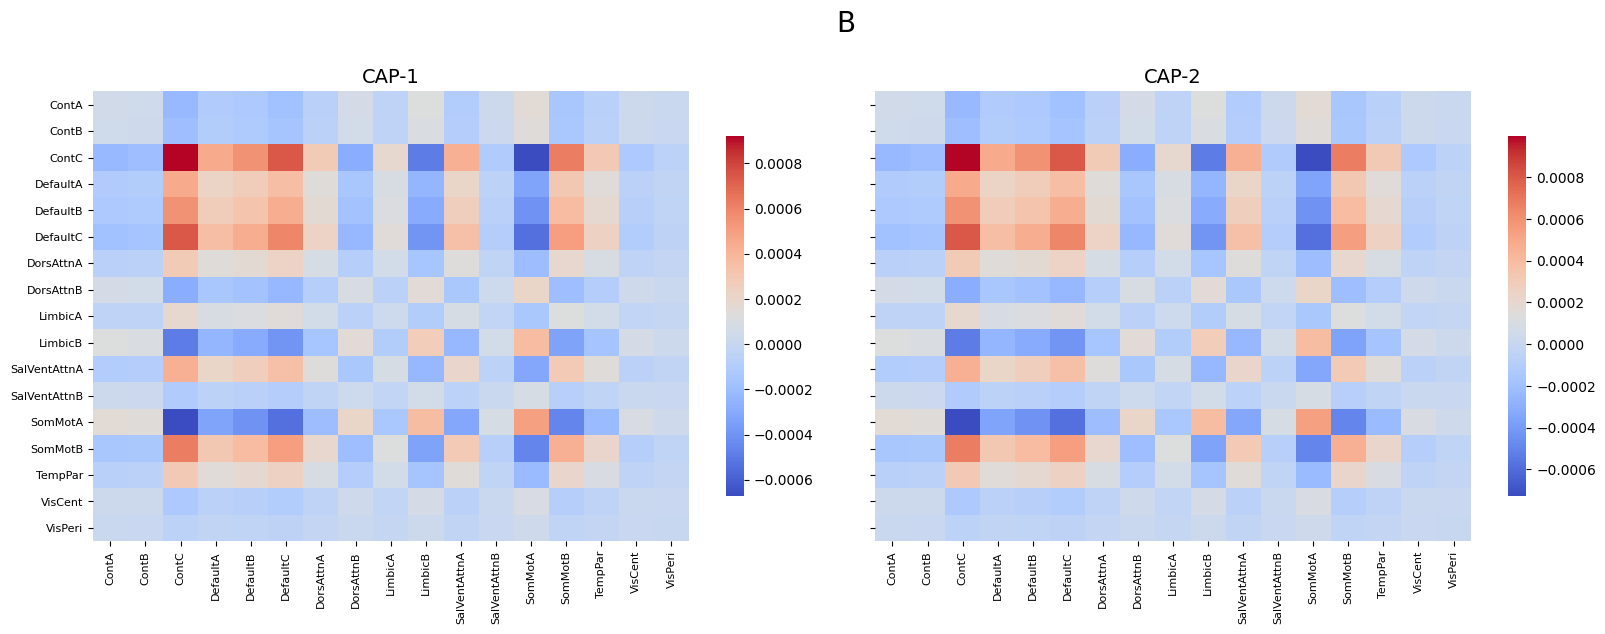

In [11]:
# Visualize Caps
cap_analysis.visualize_caps(subplots=True, xlabel_rotation=90, sharey=True)

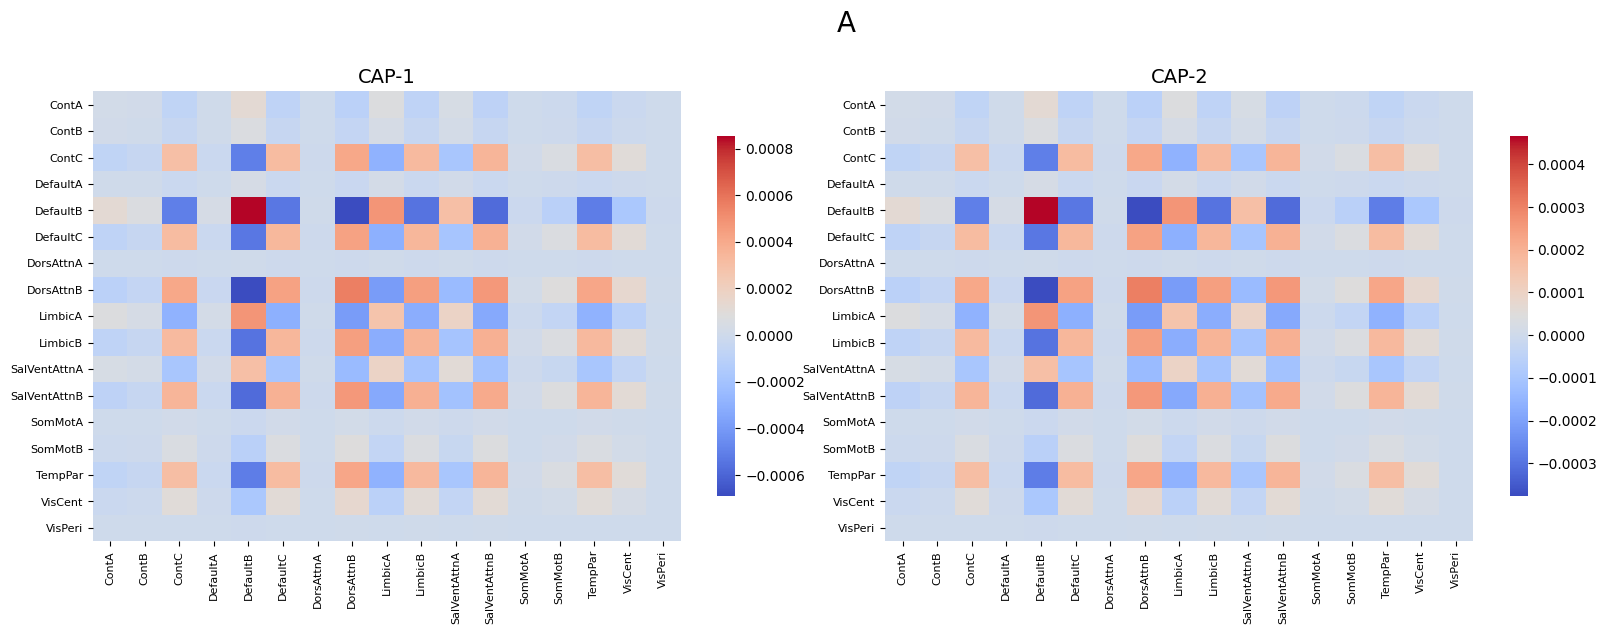

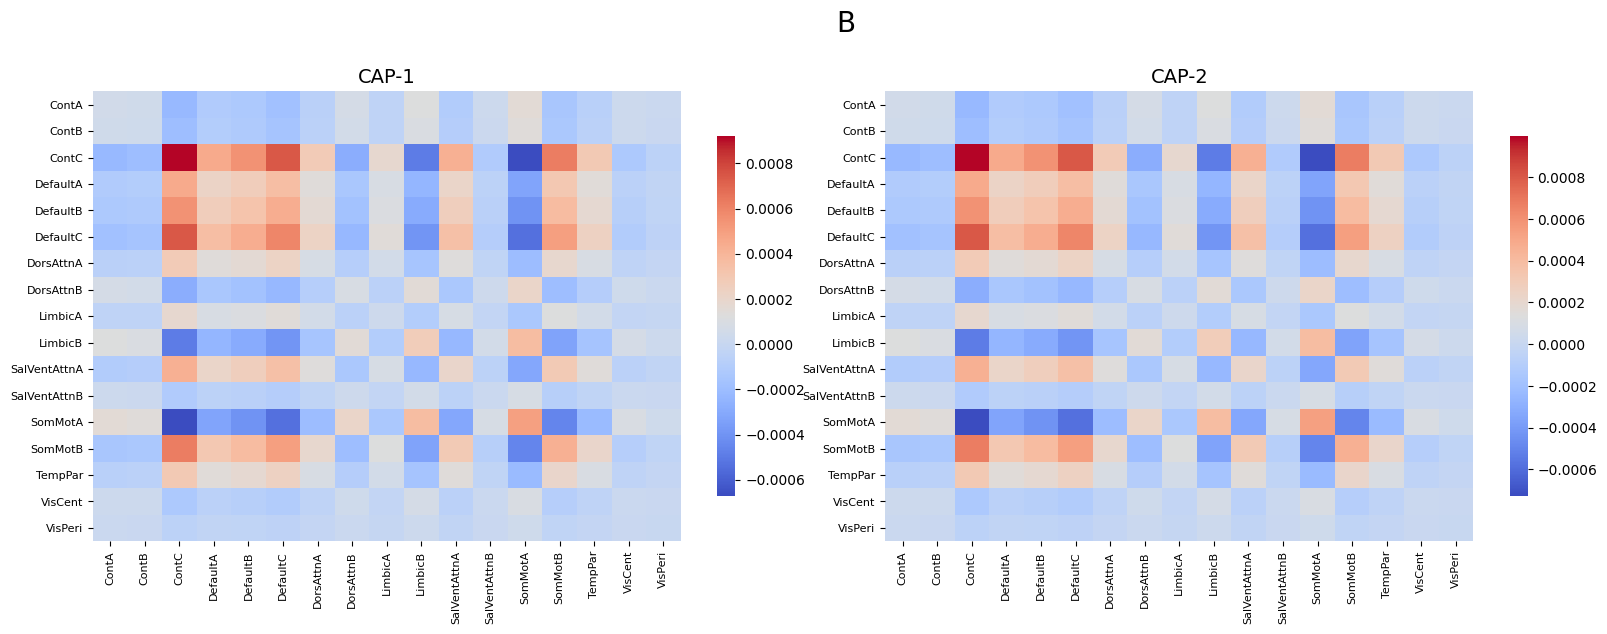

In [12]:
# Visualize Caps
cap_analysis.visualize_caps(subplots=True, xlabel_rotation=90, sharey = False)

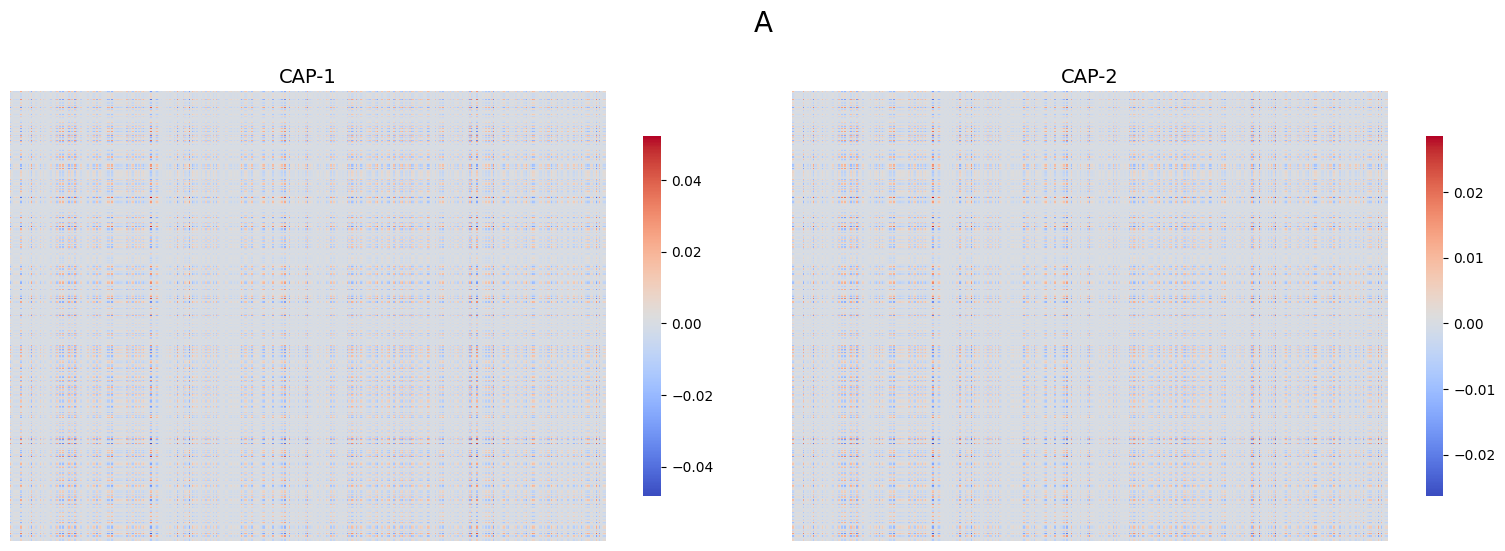

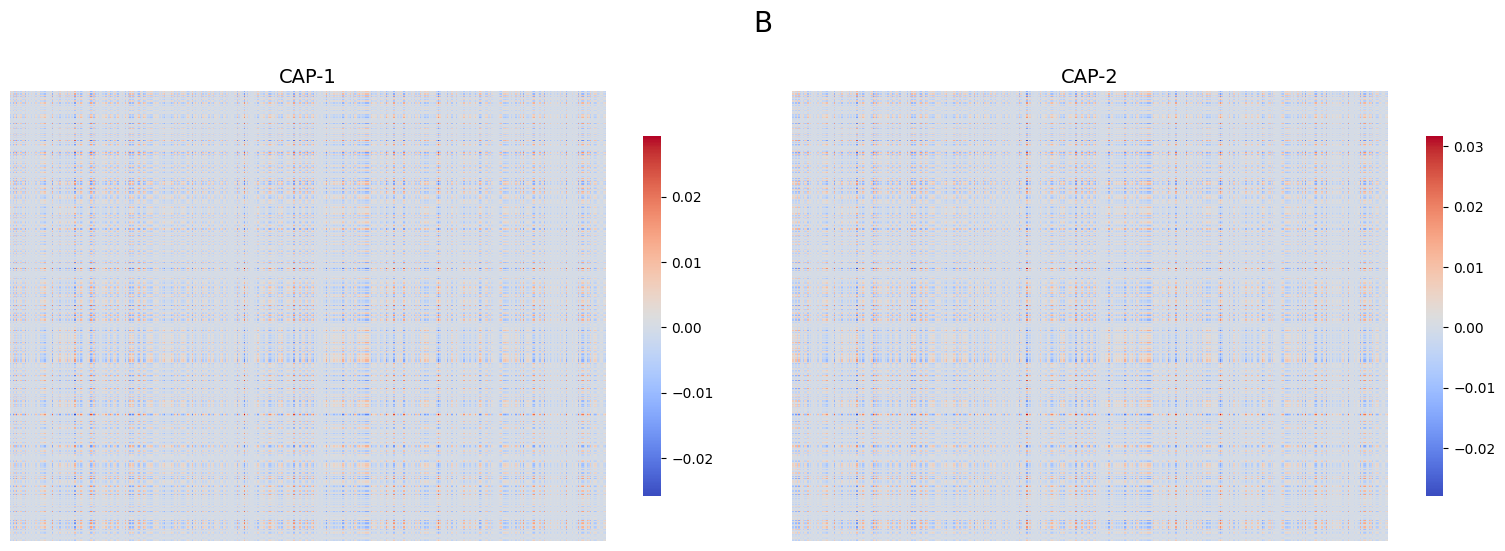

In [13]:
# Change scope from network to nodes

cap_analysis.visualize_caps(subplots=True, wspace = 0.1, visual_scope="nodes")

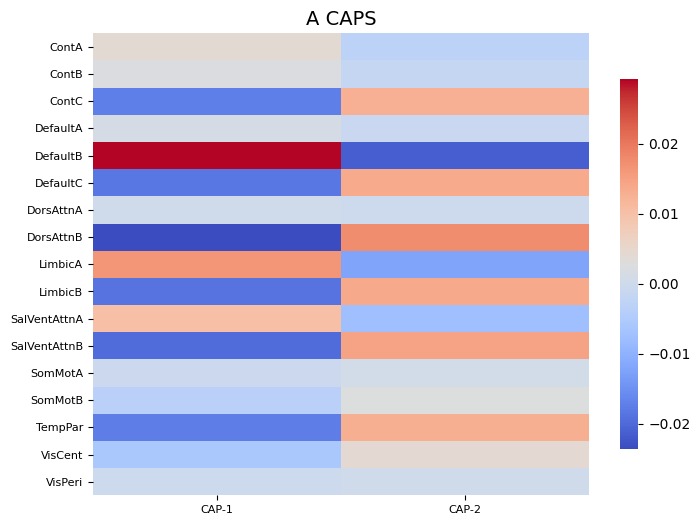

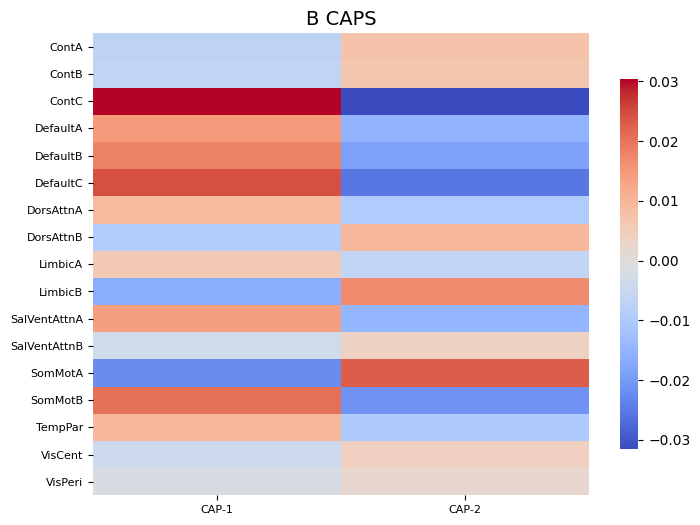

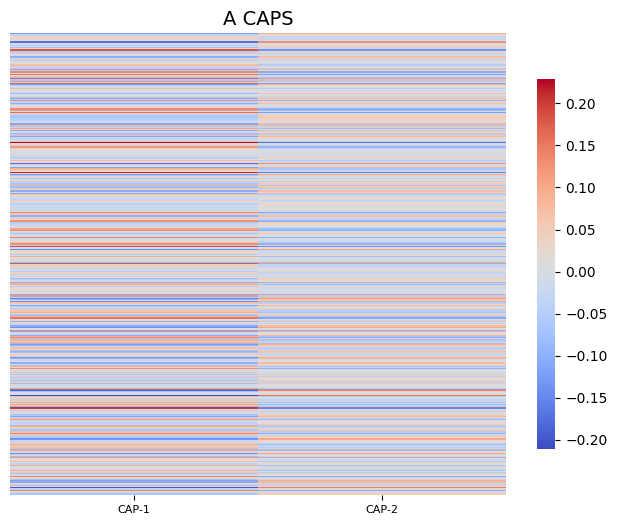

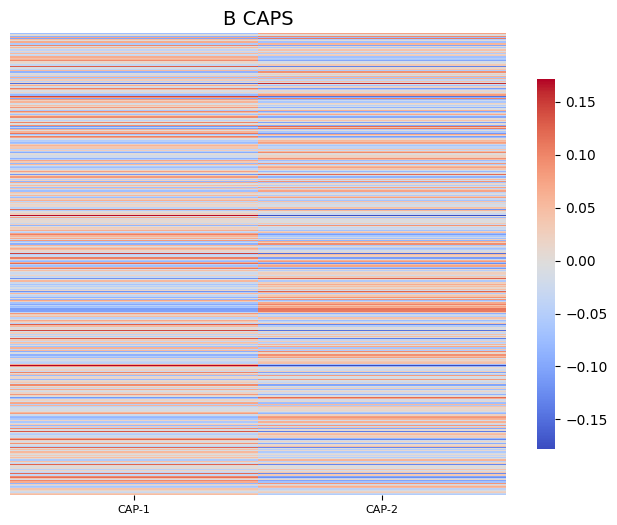

In [14]:
# Get regular heatmap 
cap_analysis.visualize_caps(subplots=True, visual_scope="networks", plot_options="heatmap")
cap_analysis.visualize_caps(subplots=True, visual_scope="nodes", plot_options="heatmap")

Invalid kwargs arguments used and will be ignored {'y': -3}.


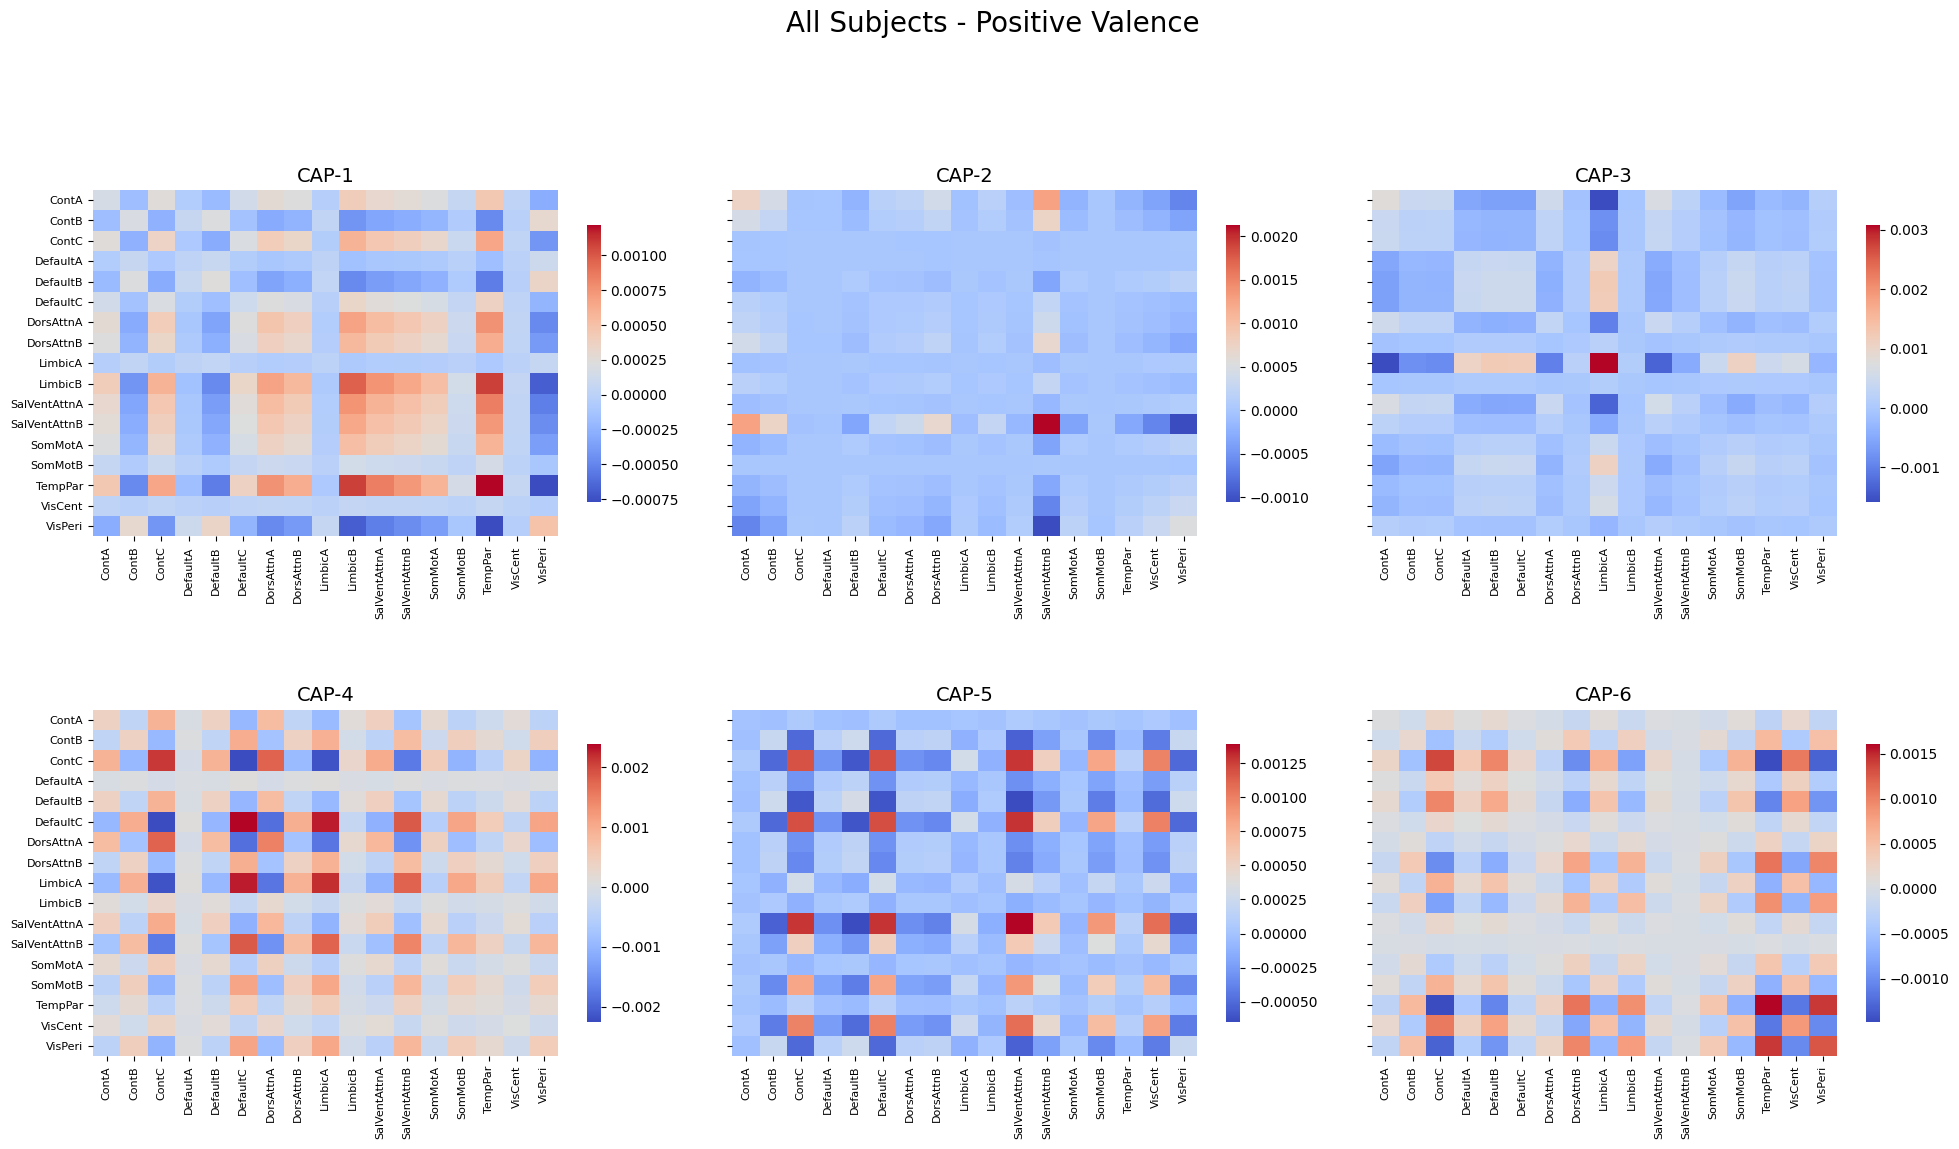

In [15]:
# Performing Cap analysis without groups or cluster selection method

cap_analysis = CAP(node_labels=extractor.atlas_labels, n_clusters=6)
cap_analysis.get_caps(subject_timeseries="sample_timeseries.pkl")

# invalid plotting keywords will be ignored and plottinf will continue
cap_analysis.visualize_caps(subplots=True, wspace = 0.1, hspace = 0.5, ncol=3, task_title="- Positive Valence", y = -3, xlabel_rotation=90, tight_layout=False, yticklabels_size=8, xticklabels_size=8)

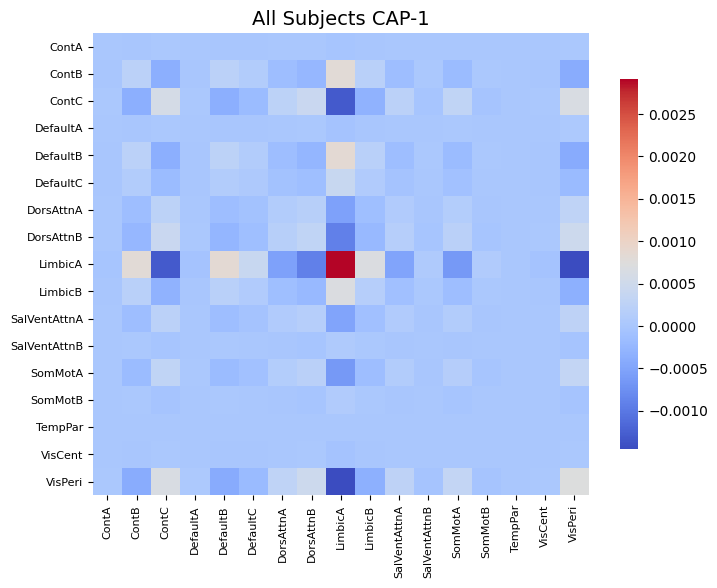

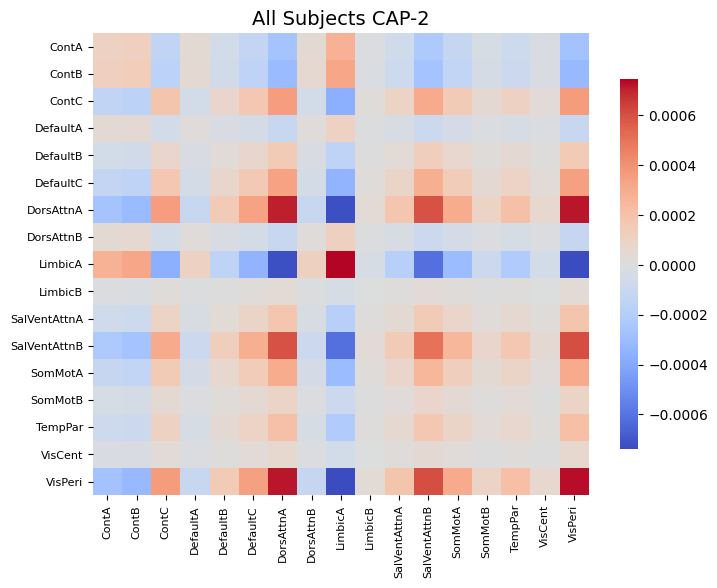

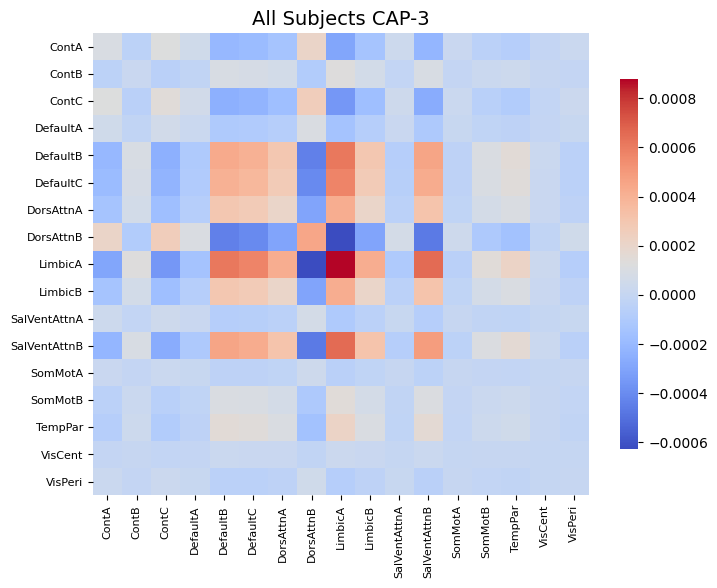

In [16]:
# Individual plots
cap_analysis = CAP(node_labels=extractor.atlas_labels, n_clusters=3)
cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries)
cap_analysis.visualize_caps(xlabel_rotation=90)

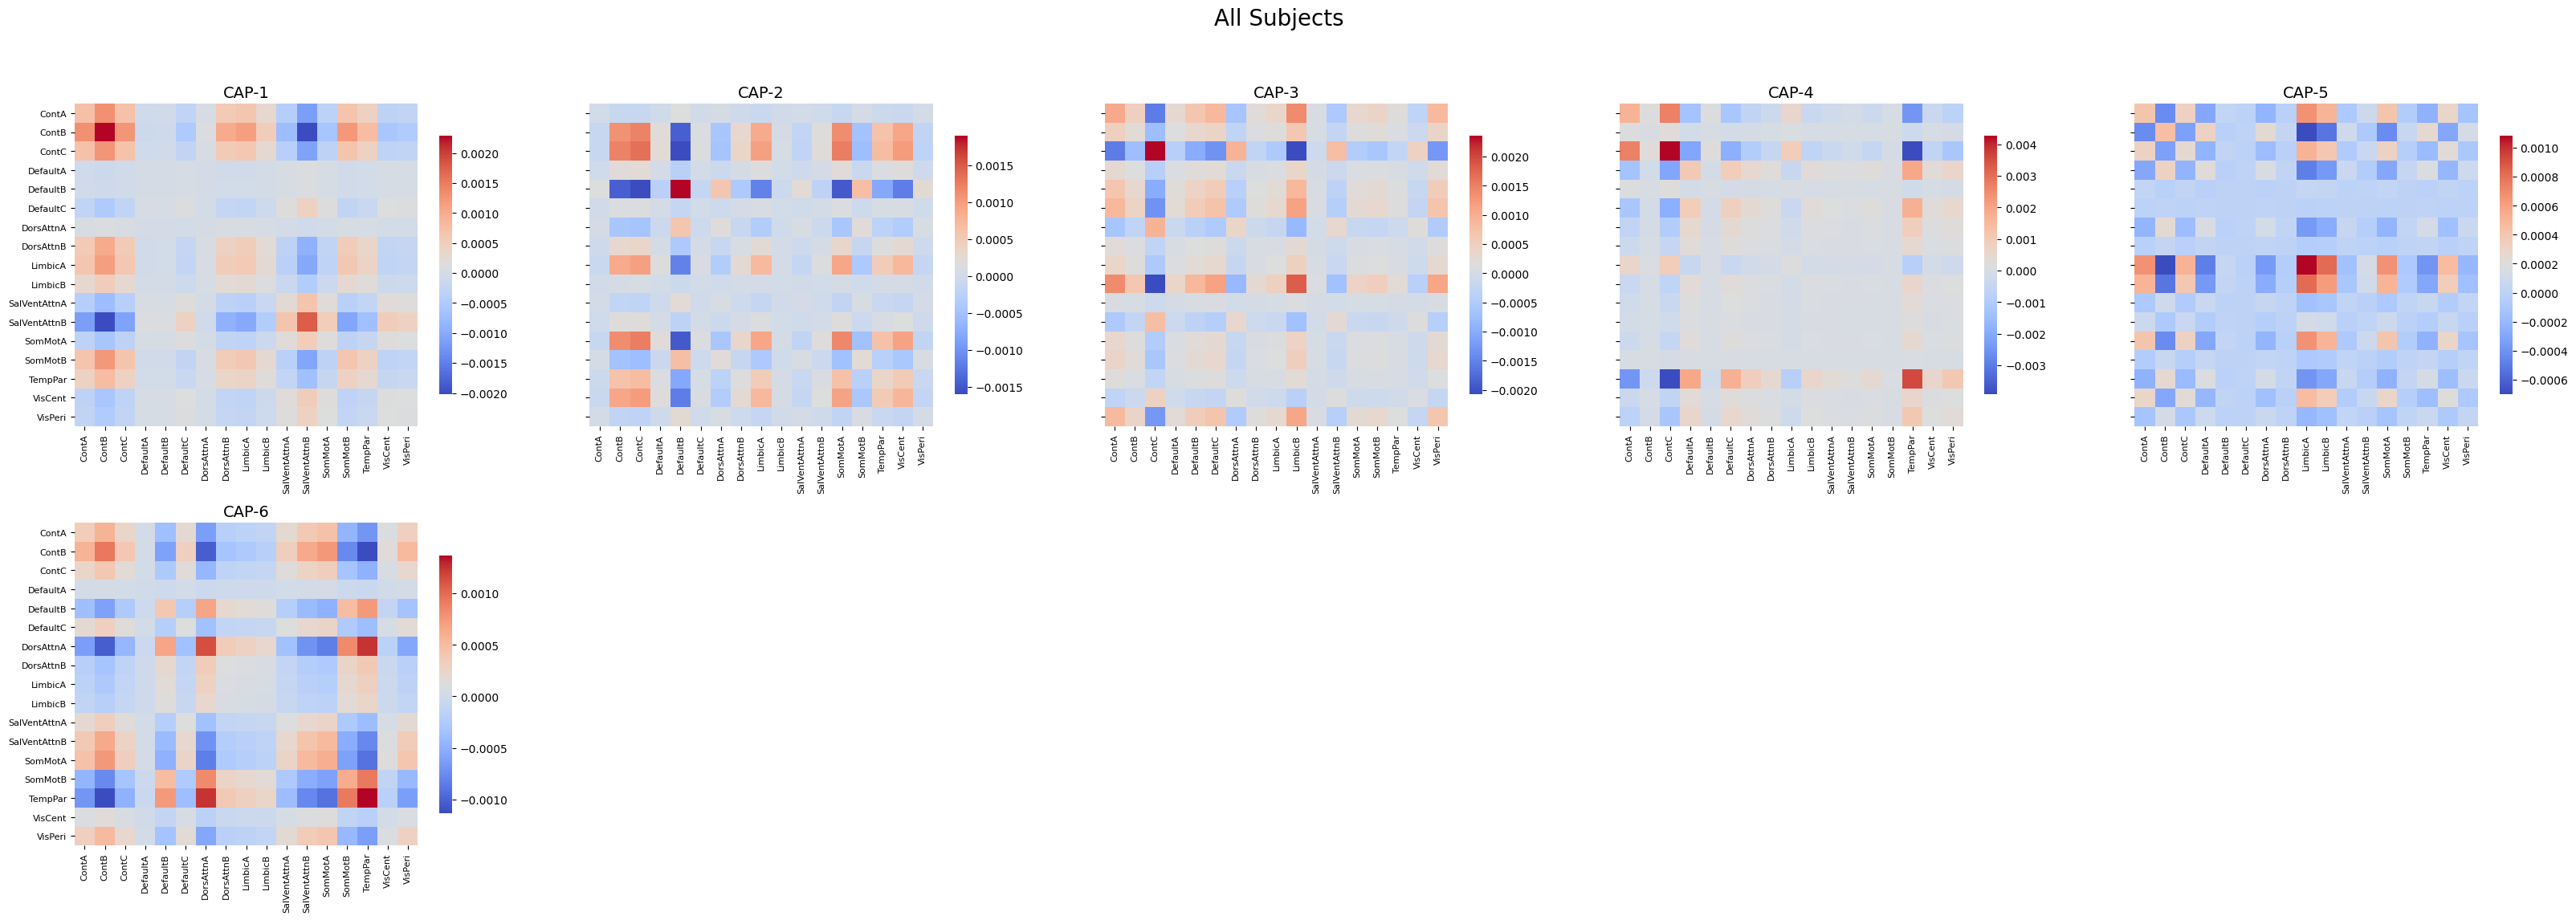

In [17]:
# Performing Cap analysis with no groups and no cluster selection method

cap_analysis = CAP(node_labels=extractor.atlas_labels, n_clusters=6)
cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries)
cap_analysis.visualize_caps(output_dir=output_dir, visual_scope="networks", plot_options="outer product", subplots=True, fontsize=14, xlabel_rotation=90, tight_layout=False, hspace=0.3)

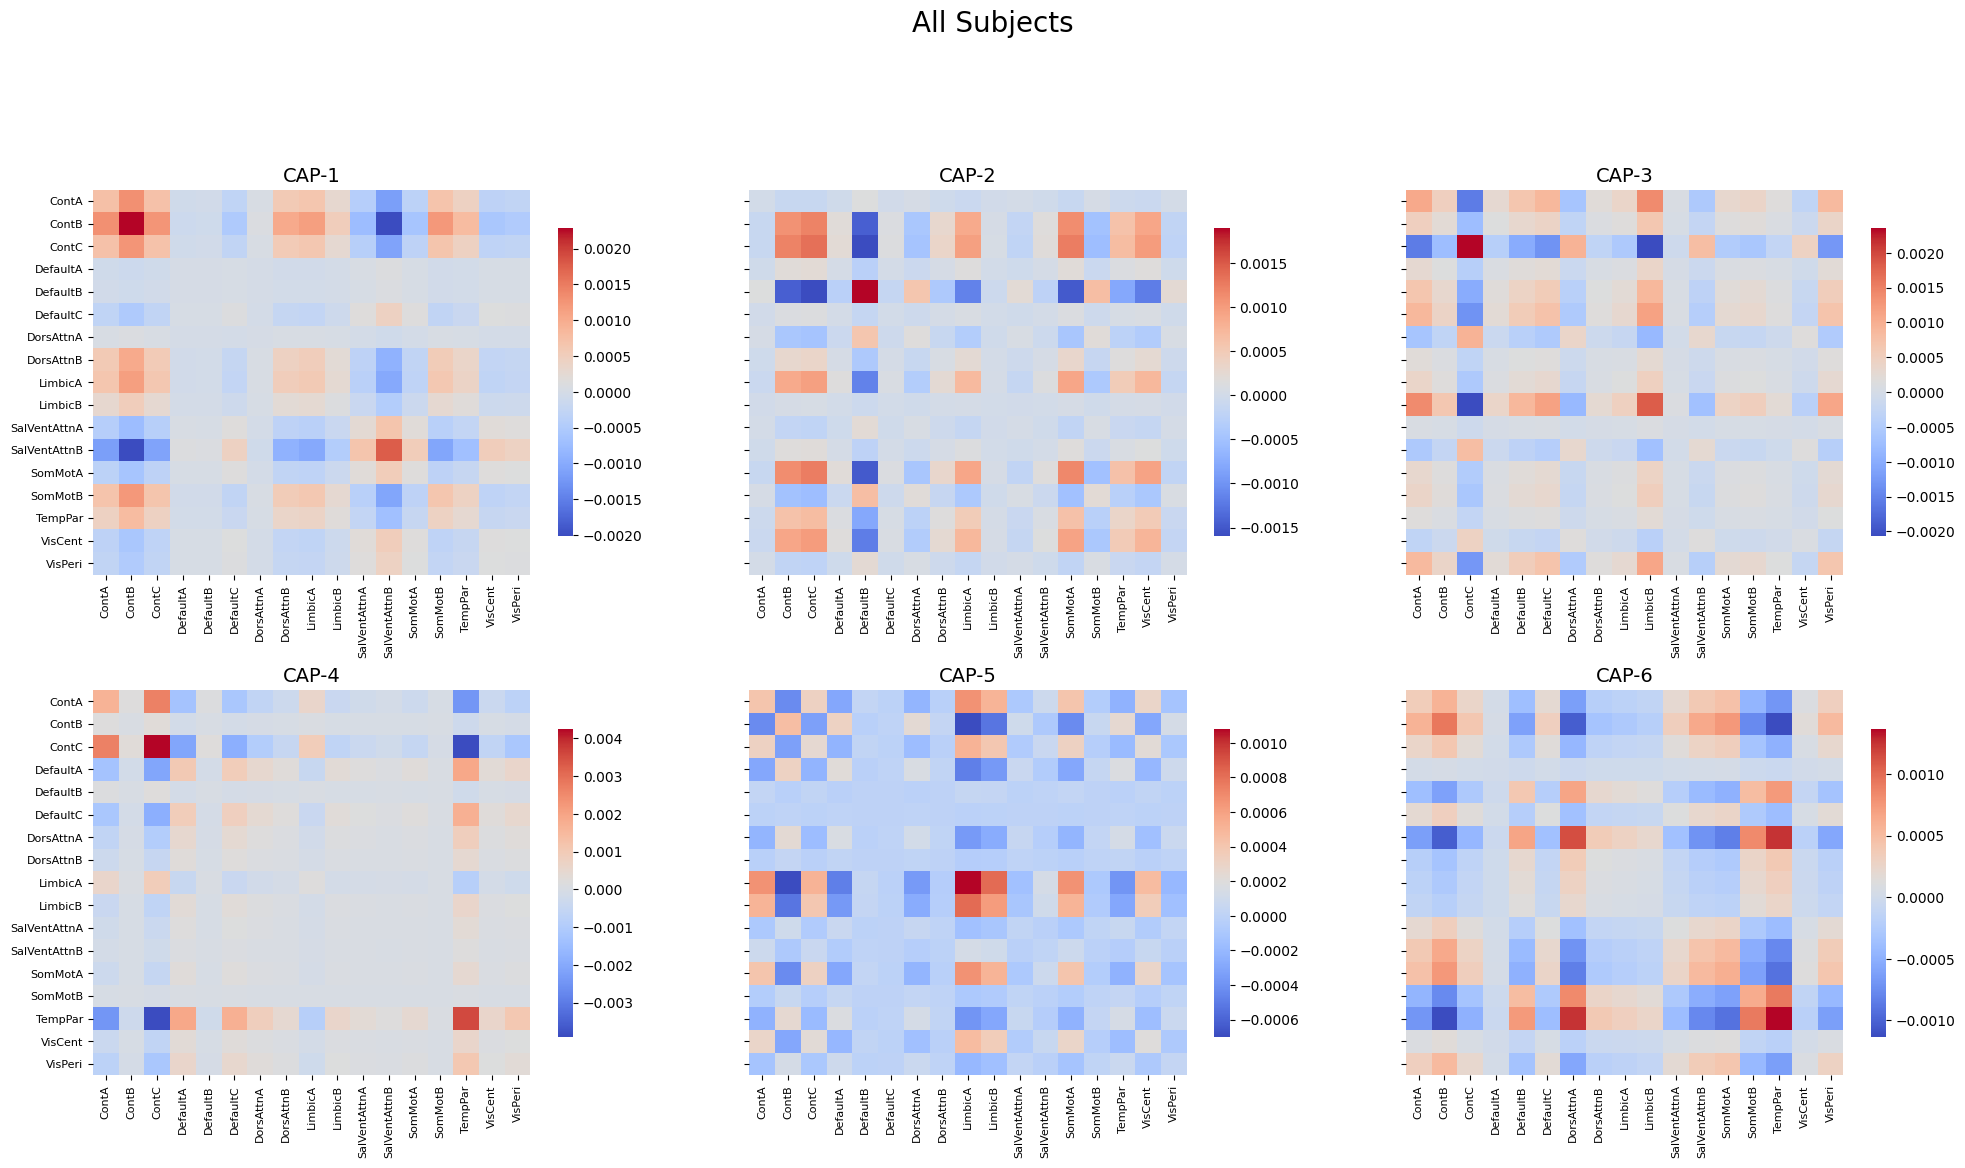

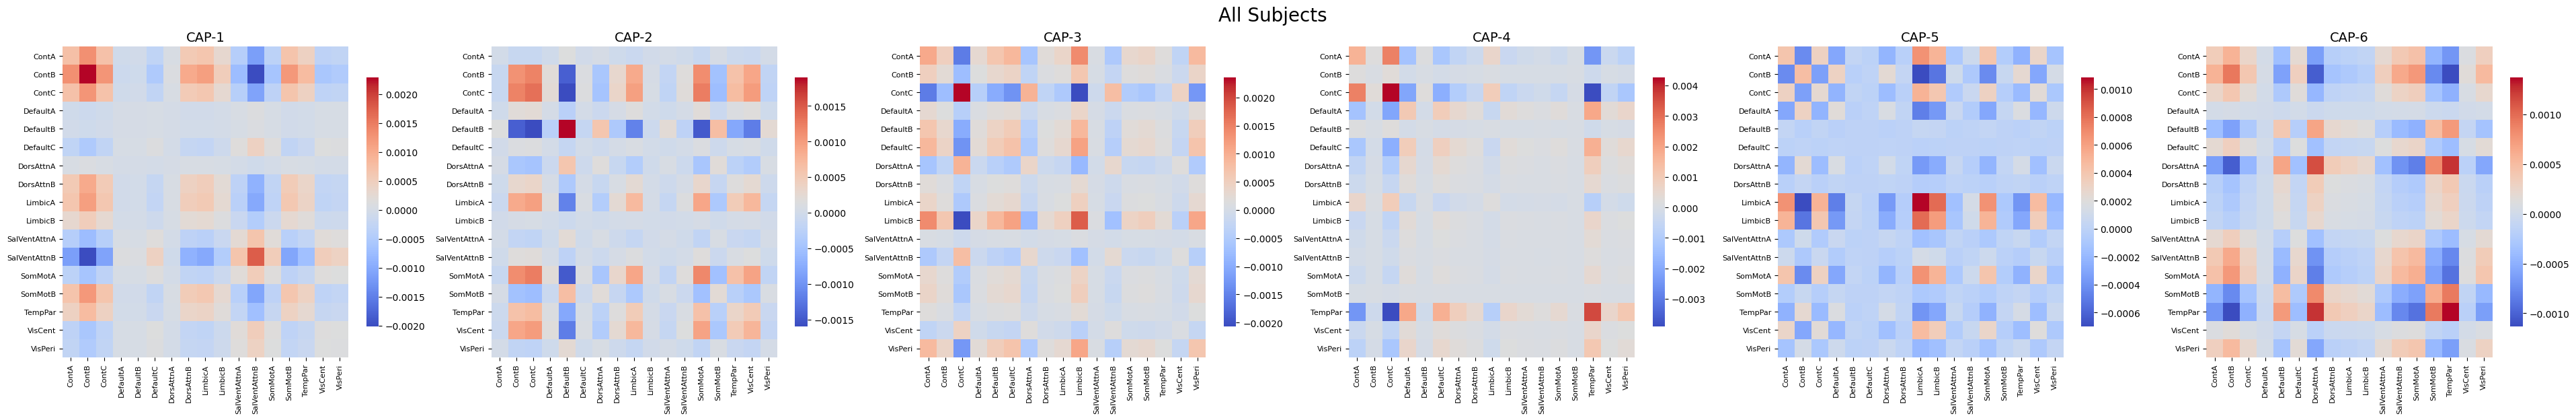

In [20]:
# Can change the number of columns for subplots. If none is specified, the default varies but will max out to five columns; however, yoe can specify more than five columns

cap_analysis.visualize_caps(output_dir=output_dir, visual_scope="networks", plot_options="outer product", subplots=True, fontsize=14, ncol=3, xlabel_rotation=90, tight_layout=False,  hspace = 0.3)
cap_analysis.visualize_caps(output_dir=output_dir, visual_scope="networks", plot_options="outer product", subplots=True, fontsize=14, ncol=6, sharey=False, tight_layout=False, xlabel_rotation=90, hspace = 0.3)

In [19]:
help(cap_analysis.visualize_caps)

Help on method visualize_caps in module neurocaps.cap:

visualize_caps(output_dir: str = None, plot_options: Union[str, list[str]] = 'outer product', visual_scope: list[str] = 'networks', task_title: str = None, show_figs: bool = True, subplots: bool = False, **kwargs) method of neurocaps.cap.CAP instance
    Plotting CAPS
    
    This function produces seaborn heatmaps for each CAP. If groups were given when the CAP class was initialized, plotting will be done for all CAPs for all groups.
    
    Parameters
    ----------
    output_dir: str, default=None
        Directory to save plots in. If None, plots will not be saved.
    plot_options: str or list[str], default="outer product"
        Type of plots to create. Options are "outer product" or "heatmap".
    visual_scope: str or list[str], default="networks
        Determines whether plotting is done at the network level or node level. For network level, the value of each nodes in the same networks are averaged together them plott